# Exercise 2

In [116]:
import matplotlib.pyplot as plt
import math
import numpy as np

In [218]:
# Initial Conditions

# define step width and global steps
t: int = 100
dt: float = 0.01
N: int = int(t/dt)

# Define Parameters
sigma: int = 10
rho: int = 28
betta: float = 8/3

# define zi_0
x_0: float = -0.587
y_0: float = -0.563
z_0: float = 16.870

zt_0 = np.array([x_0, y_0, z_0])

# Define initial gn
a: float = 1/math.sqrt(dt)
g_00: float = a * ((2 ** (-1/2)) - 1/2)
g_01: float = a * ((3 ** (-1/2)) - 1/2)
g_02: float = a * ((5 ** (-1/2 )) - 1/2)
g_n = np.array([g_00, g_01, g_02])

In [219]:
def tent_map(gn: np.array, a: float) -> float:
    """
    Takes gn with dim=N3 and a as a float.
    it will perform the tent map transformation on error g_n to produce the error for gn + 1
    :param gn: the error state at time n
    :param a: 1/sqrt(dt)
    :return: gn + 1
    """
    # set the values to -2 only if a is gni is outside that range
    i1: np.array = np.array([-2, -2, -2])
    i1[np.where((-a/2 <= gn) & (gn < 0))] = 2

    return (gn * i1) + a/2

In [220]:
def fz(zt: np.array) -> np.array:
    """
    perform f(z) function
    :param zt: current state z
    :return: f(zt)
    """
    # unpack the values x, y, z
    x, y, z = zt

    return np.array([
        sigma * (y - x),
        x * (rho - z) - y,
        (x * y) - (betta * z)
    ])

In [221]:
def forward_euler(zt: np.array, gn: np.array, dt: float) -> np.array:
    """
    Perform the forward euler step
    :param zt: current state
    :param gn: current error
    :param dt: delta t (time step)
    :return: zt +1
    """
    return zt + dt * (fz(zt=zt) + gn)

In [222]:
x_coordinates = [x_0]
y_coordinates = [y_0]
z_coordinates = [z_0]

z_k = zt_0
for i in range(N):
    # update z_k
    z_k = forward_euler(zt=z_k, gn=g_n, dt=dt)

    # update error
    g_n = tent_map(gn=g_n, a=a)

    # append coordinates every step of t
    x, y, z = z_k
    x_coordinates.append(x)
    y_coordinates.append(y)
    z_coordinates.append(z)


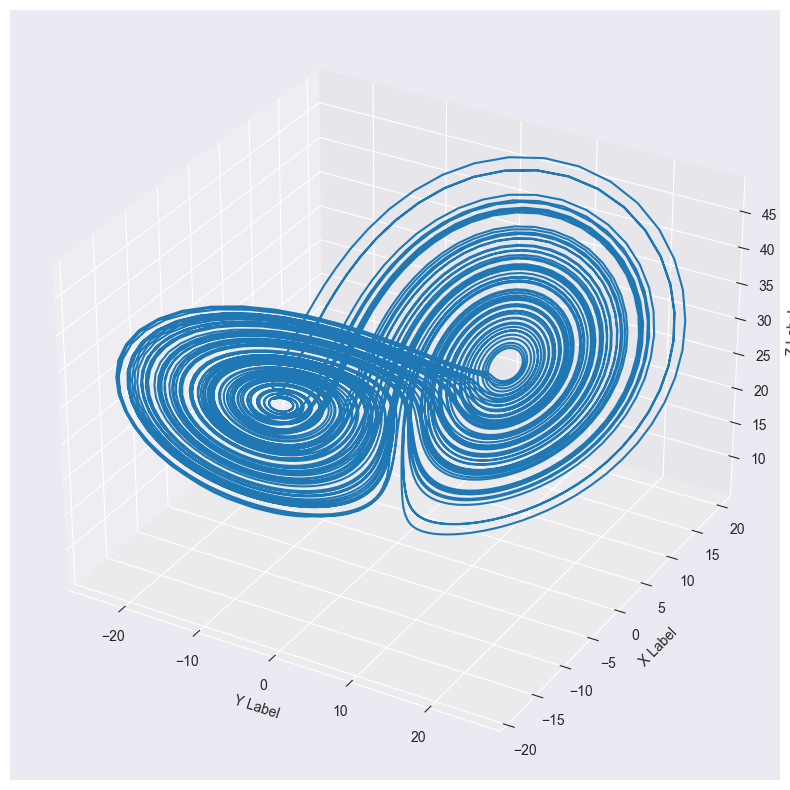

In [223]:
ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')
ax.plot(y_coordinates, x_coordinates,  z_coordinates, label="Attention Switched X and Y position")

# Set labels
ax.set_xlabel('Y Label')
ax.set_ylabel('X Label')
ax.set_zlabel('Z Label')


# set labels
plt.show()

# Task 2

In [225]:
a = 4
exi_0 = a * ((2 ** (-1/2)) - 1/2)

In [ ]:
def modified_tent_map(exi_k: np.array, a: float):
    # set the values to -2 only if a is gni is outside that range
    i1: np.array = np.array([-2, -2, -2])
    i1[np.where((-a/2 <= exi_k) & (exi_k < 0))] = 2

    return (exi_k * i1) + a/2

In [227]:
x_coordinates = [x_0]
y_coordinates = [y_0]
z_coordinates = [z_0]

z_k = zt_0
g_n = exi_0
for i in range(N):
    # update z_k
    z_k = forward_euler(zt=z_k, gn=g_n, dt=dt)

    # update error
    g_n = tent_map(gn=g_n, a=a)

    # append coordinates every step of t
    x, y, z = z_k
    x_coordinates.append(x)
    y_coordinates.append(y)
    z_coordinates.append(z)


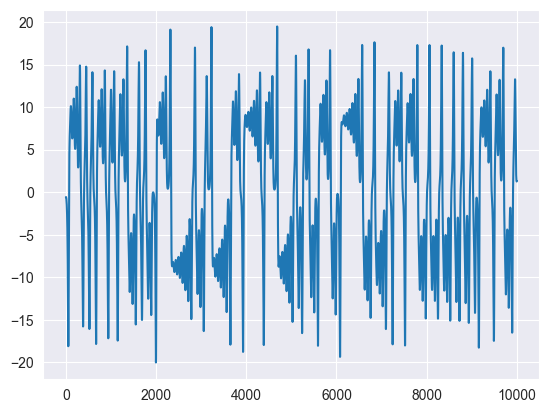

In [228]:
plt.plot(x_coordinates)

# set labels
plt.show()